In [1]:
from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
import os

from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
import sys
import functools
import pickle

import jax
import jax.numpy as jnp
from jax import jit, jacfwd

from netCDF4 import Dataset

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries

from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import flatten_list

from desc.utils import Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif, cross, dot

from desc.optimize import lsqtr, lsq_auglag

from desc.magnetic_fields import FourierCurrentPotentialField

import time

import numpy as np
from numpy import ndarray

from desc.fns_simp import (plot_figure, plot_figure2, plot_xy,
                           surf_int,
                           _compute_magnetic_field_from_Current)

from find_sour import alt_grid, interp_grid, iso_coords_interp
from find_sour_vec import bn_res_vec#,iso_coords_interp

In [3]:
def segment_array(array_size, num_segments):
    """
    Divide an array of given size into specified number of segments.
    Returns a list of tuples containing (start_index, end_index) for each segment.
    """
    if array_size < 0 or num_segments <= 0:
        return []
    
    segment_size = array_size // num_segments
    remainder = array_size % num_segments
    segments = []
    current_index = 0
    
    for i in range(num_segments):
        # Calculate segment length, distributing remainder across initial segments
        current_segment_size = segment_size + (1 if i < remainder else 0)
        if current_segment_size > 0:  # Only add non-empty segments
            segments.append((current_index, current_index + current_segment_size - 1))
            current_index += current_segment_size
            
    return segments

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

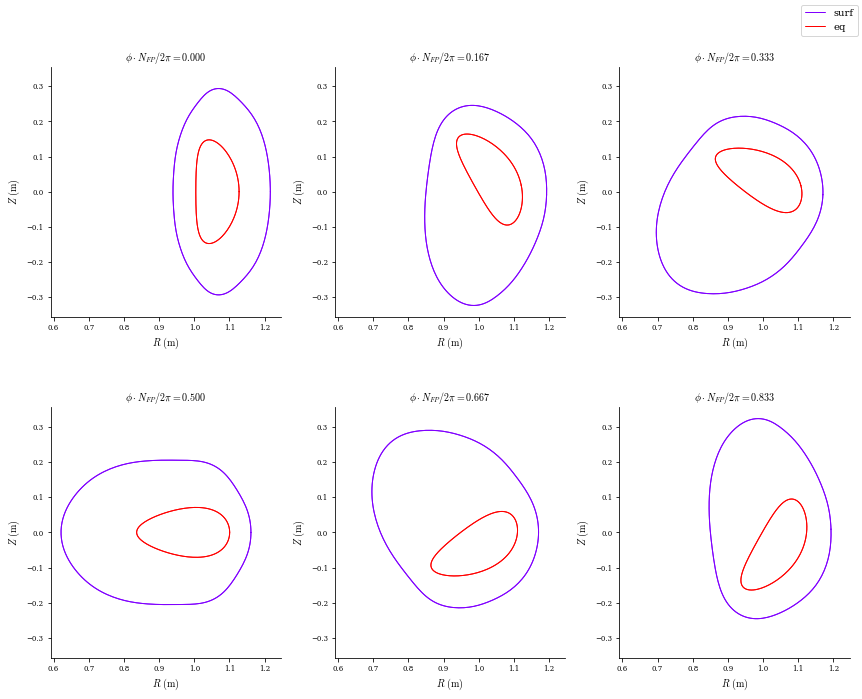

In [4]:
# Plasma surfaces
eqname_QA = "/scratch/gpfs/fcastro/LMStell/regcoil/rogerio/input.QA_final_output.h5" #vacuum equilibrium
eq_QA = desc.io.load(eqname_QA)[4]

eq = eq_QA

name = 'iso_coords/'

# Winding surface
surf_winding = load(name + "surf.h5")

# Plot both surfaces
plot_comparison([surf_winding,eq],labels=["surf","eq"],theta=0,rho=np.array(1.0))

In [5]:
# Evaluate Green's function for flat tori
sgrid = LinearGrid(M = 100, N = 100, NFP = surf_winding.NFP,)
sdata = surf_winding.compute(["theta","zeta", "e^theta_s","e^zeta_s",'x'], grid = sgrid)
sdata = iso_coords_interp(name, sdata, sgrid, surf_winding)

G = np.load(name + "G.npy")
K_sec = G * cross(sdata["n_rho"], sdata["e^u_s"])
K_sv = surf_winding.compute(["K"],grid = sgrid)["K"]

In [6]:
sgrid2 = Grid(nodes = jnp.vstack((sgrid.nodes[:,0], sgrid.nodes[:,1],
                                  sgrid.nodes[:,2] + (2*np.pi/surf_winding.NFP)*1)).T
             )
sgrid3 = Grid(nodes = jnp.vstack((sgrid.nodes[:,0], sgrid.nodes[:,1],
                                  sgrid.nodes[:,2] + (2*np.pi/surf_winding.NFP)*2)).T
              )

sdata2 = surf_winding.compute(["theta","zeta", "e^theta_s","e^zeta_s"], grid = sgrid2)
sdata2 = iso_coords_interp(name, sdata2, sgrid2, surf_winding)

sdata3 = surf_winding.compute(["theta","zeta", "e^theta_s","e^zeta_s"], grid = sgrid3)
sdata3 = iso_coords_interp(name, sdata3, sgrid3, surf_winding)

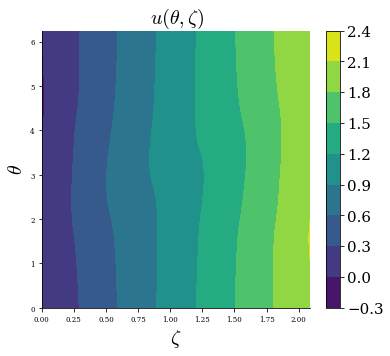

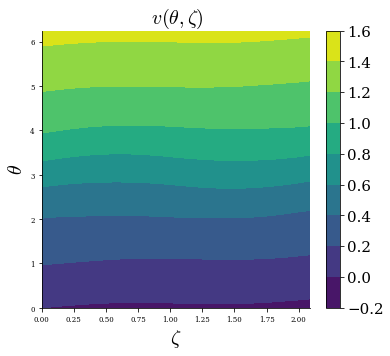

In [7]:
# Confirm that variables have the same shape
plot_figure2(sdata["u_iso"],sgrid,''r' $ u(\theta,\zeta)$ ')
plot_figure2(sdata["v_iso"],sgrid,''r' $ v(\theta,\zeta)$ ')
#plot_figure2(sdata["lambda_iso"],sgrid,''r' $ \lambda $ ')

#plot_figure2(sdata2["u_iso"],sgrid2,''r' $ u(\theta,\zeta)$ ')
#plot_figure2(sdata2["v_iso"],sgrid2,''r' $ v(\theta,\zeta)$ ')

#plot_figure2(sdata3["u_iso"],sgrid3,''r' $ u(\theta,\zeta)$ ')
#plot_figure2(sdata3["v_iso"],sgrid3,''r' $ v(\theta,\zeta)$ ')

In [8]:
eps = 1e-2
dt = eps
dz = eps
d0 = eps/3

In [9]:
grid_M = 20
grid_N = 20

In [10]:
egrid = LinearGrid(M = grid_M, N = grid_N, NFP = eq.NFP)
edata = eq.compute(["n_rho","B"], grid = egrid)

#B_s = edata["B"]
B_sec = np.load('iso_coords/B_sec_'+str(grid_M)+'x'+str(grid_N)+'.npy')
#_compute_magnetic_field_from_Current( sgrid, K_sec, surf_winding, eq, egrid, basis = "rpz" )
B_s = _compute_magnetic_field_from_Current( sgrid, K_sv, surf_winding, eq, egrid, basis = "rpz" )
#B_s = _compute_magnetic_field_from_Current( sgrid, K_sec, surf_winding, eq, egrid, basis = "rpz" )
rhs = jnp.concatenate((B_s[:,0],B_s[:,1],B_s[:,2],
                      jnp.asarray([0])))
#- dot( edata["n_rho"],  B_sec )

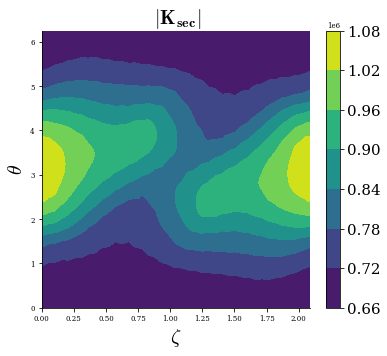

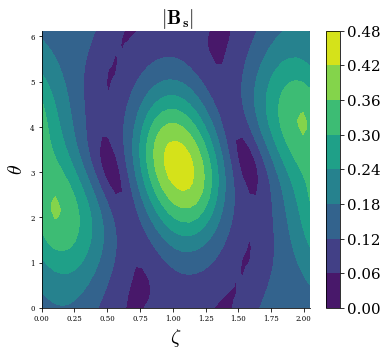

In [11]:
plot_figure2( dot(K_sec,K_sec) ** (1/2), sgrid,''r' $ | \mathbf{K_{sec}} |$ ')
plot_figure2( dot(B_s,B_s) ** (1/2), egrid,''r' $ | \mathbf{B_{s}} |$ ')
#plot_figure2( rhs, egrid, ''r' $ \mathbf{B_{sec} \cdot n}$ ' )

In [12]:
N = 20 # Terms toa pproximate the infinite series

# Numer of dipoles
sMv = np.asarray([30,])
sNv = np.asarray([30,])

In [13]:
grid_M2 = grid_M
grid_N2 = grid_N

egrid2 = LinearGrid(M = grid_M2, N = grid_N2, NFP = eq.NFP)
edata2 = eq.compute(["n_rho"], grid = egrid2)

B_sec2 = np.load('iso_coords/B_sec_' + str(grid_M2)+'x' + str(grid_N2)+'.npy')
#_compute_magnetic_field_from_Current( sgrid, K_sec, surf_winding, eq, egrid2, basis = "rpz" )
B_s2 = _compute_magnetic_field_from_Current( sgrid, K_sv, surf_winding, eq, egrid2, basis = "rpz" )
#B_s2 = edata2["B"]

In [14]:
p_M = sMv[0]
p_N = sNv[0]

theta = jnp.linspace(2 * jnp.pi * (1 / (p_M * 2+1)) * 1/2,
                         2 * jnp.pi * (1 - 1 / (p_M * 2+1) * 1/2),
                         p_M * 2+1)

zeta = jnp.linspace(2 * jnp.pi / surf_winding.NFP * (1 / (p_N * 2+1)) * 1/2,
                            2 * jnp.pi / surf_winding.NFP * (1 - 1 / (p_N * 2+1) * 1/2),
                            p_N * 2+1,)
    
name = "iso_coords/"
source_data = interp_grid(theta, zeta, surf_winding, name)

# Generate the indices for the block evaluation of Biot Savart for each source
num_segments = 5
array_size = source_data['theta'].shape[0]
result = segment_array(array_size, num_segments)
print(f"Array size: {array_size}, Number of segments: {num_segments}")
for start, end in result:
    print(f"Segment: start={start}, end={end}")

Array size: 3721, Number of segments: 5

Segment: start=0, end=744

Segment: start=745, end=1488

Segment: start=1489, end=2232

Segment: start=2233, end=2976

Segment: start=2977, end=3720

In [15]:
coords = eq.compute('x', grid = egrid)['x']

In [16]:
for i in range(0,num_segments):
    
    bn_ij = bn_res_vec(sdata, sdata2, sdata3,
                   sgrid, surf_winding,
                   N, d0,
                   coords, source_data, 
                   result[i][0], result[i][1]+1,
                   )

    #print(str(result[i][0])+ ',' +str(result[i][1]+1))
    #jnp.save('./arrays/B_M_' + str(p_M) + '_N_' + str(p_N) + '_pos_' + str(i) + '_' + str(j) + '.npy' ,bn_ij)
    if i == 0:
        A = bn_ij
    else:
        A = jnp.column_stack((A,bn_ij))

In [17]:
A = np.vstack([A,np.ones((1, A.shape[1]))])

In [18]:
U, S, Vt = jnp.linalg.svd(A, full_matrices=False)

In [19]:
jnp.save('A_M_' + str(p_M) + '_N_' + str(p_N) + '.npy' , A)
jnp.save('U_M_' + str(p_M) + '_N_' + str(p_N) + '.npy',U)
jnp.save('S_M_' + str(p_M) + '_N_' + str(p_N) + '.npy',S)
jnp.save('Vt_M_' + str(p_M) + '_N_' + str(p_N) + '.npy',Vt)